# 动量失效模型

参考**数量化投资技术系列报告之三十二** 基于动量失效的量化择时策略探讨

广义上来讲，任何利用前期的规律沿着趋势前进的现象的失效，都可以称作动量失效。

在对因子贡献度的动量失效情况进行解释之后，我们发现动量的失效点往往发生在市场的拐点处，而这似乎也并不是一个巧合。加速度总是提
前于速度形成拐点，传统量化择时方法总是偏于右侧，原因就是着眼于“速度”的策略必须等待速度形成新的趋势才可确认。

市场朝一个方向发展到一定程度，则会向相反的方向进行转化，而这一原有规律的失效恰恰是两种相反方向起始与终结的拐点。在知晓拐点处的失效情况后，我们便开始着手判断市场的动量失效时点。

## 数据概述

* Wind获得沪深300的收盘数据
* 数据频率：15分钟
* 数据采用前复权价格
* 时间区间：2017-01-01-->2020-03-27

## 价格动量的定义 

价格动量是根据过去的价格信息来推断未来的趋势。

参照 MACD 指标的编制原理，我们会利用快速（短期）和慢速（长期）两条均线的位置和走势等股票的价格动量信息来判断股票下一步的动向，并从不同频度来加强我们的判断。

我们根据周期长短，分别考虑以下频率的价格：**15 分钟、1 小时、1 日、1 周**。

最短的频率为 15 分钟，故以 15 分钟为基本单位，则各频率可表示为：

* 1 小时=4*15 分钟

* 1 日=16*15 分钟

下面会将 4 和 16 作为短期和长期的划分长度，而每 15 分钟取当时的 15 分钟价格、小时价格、日价格和周价格进行价格动量指标的构建。

## 指标的构建 
1. 计算移动平均值（EMA）

短期：EMA（4）=前一刻钟 EMA（4）×3/5＋当前刻钟收盘价×2/5
长期：EMA（16）=前一刻钟 EMA（16）×15/17＋当前刻钟收盘价×2/17

2. 计算离差值（DIF）DIF=当前刻钟 EMA（4）-当前刻钟 EMA（16）

3. 前期高低点
前期的定义：根据变点数据所得到的拐点，将当期之前经历的一个完整趋势至今定义为前期。如当期 2009.4.5 之前有两个拐点 2008.11.7 和2009.1.20，则将 2008.11.7 至 2009.4.5 作为前期。

    * 前期最高价：即前期所出现的最高收盘价（在 15 分钟、小时、日、周上会有所区别）
    * 前期最低价：即前期所出现的最低收盘价
    * 前期最高 DIF：即前期所出现的最高 DIF 值前期
    * 最低 DIF：即前期所出现的最低 DIF 值

## 指标的运用 

1. 突破的确定若当期价格超过前期最高价或低于前期最低价，则称为突破；同理对于 DIF 指标。
2. 背离的确定若价格突破前期最高价（或最低价），而 DIF 指标未突破则称为背离，分钟、小时、日、周同时出现背离，则判断为出现反转。在此我们暂不对顶背离和底背离做出区别，统一为反转。后面会将反转具体分为上涨动量失效点（顶背离）和下跌动量失效点（底背离）。

启动Wind API，从Wind获取数据

In [58]:
from WindPy import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
w.start()
error,data_df=w.wsi("000300.SH", "close", "2017-01-01 09:00:00", "2020-03-27 14:25:00", "BarSize=15;Fill=Previous", usedf=True)

assert error == 0, "API数据提取错误，ErrorCode={}，具体含义请至帮助文档附件《常见API错误码》中查询。".format(error)

data_df.head()

,close
2017-03-29 09:45:00,3467.84
2017-03-29 10:00:00,3469.93
2017-03-29 10:15:00,3457.15
2017-03-29 10:30:00,3459.14
2017-03-29 10:45:00,3464.31


分别按照各个时间频度（15 分钟、1 小时、1 日、1 周）计算对应的收盘价，并计算对应的4期和16期的移动平均值（EMA），并相减得到离差值

In [136]:
mul=(1,4,16,80)


def cal_ma(df):
    MA_list=[4,16]
    for ma in MA_list:
        df['ema'+str(ma)]=df['close'].ewm(span=ma).mean()
    df['dif']=df['ema4']-df['ema16']
    return df
df_list={}
for m in mul:
    if m==1:
        buf_df=data_df
    else:
        close_m=np.zeros(data_df['close'].shape)
        for i in range(data_df.shape[0]):
            close_m[i]=data_df['close'][int(i/m)*m]
        buf_df=pd.DataFrame(close_m,columns=['close'])
    buf_df=cal_ma(buf_df)
    df_list[m]=buf_df
# data_df
df_list.keys()
df_list[1].tail(10)

,close,ema4,ema16,dif
2020-03-27 10:45:00,3732.0968,3727.044550,3718.169529,8.875021
2020-03-27 11:00:00,3719.7618,3724.131450,3718.356855,5.774595
2020-03-27 11:15:00,3730.1951,3726.556910,3719.749590,6.807320
2020-03-27 11:30:00,3757.1000,3738.774146,3724.143756,14.630390
2020-03-27 13:15:00,3735.1490,3737.324088,3725.438490,11.885597
2020-03-27 13:30:00,3729.8879,3734.349613,3725.961950,8.387662
2020-03-27 13:45:00,3734.4973,3734.408688,3726.966109,7.442579
2020-03-27 14:00:00,3737.0332,3735.458493,3728.150473,7.308020
2020-03-27 14:15:00,3730.6946,3733.552936,3728.449782,5.103154
2020-03-27 14:30:00,3724.8074,3730.054721,3728.021266,2.033455


将15分钟频度收盘价和离差值得图像绘制如下

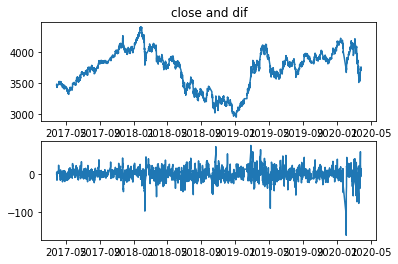

In [137]:
fig=plt.figure()
ax=plt.subplot(211)
ax.plot(df_list[1]['close'])
ax.set_title('close and dif')
ax=plt.subplot(212)
ax.plot(df_list[1]['dif'])

plt.show()

此处使用从变点择时策略中得到的变点数据（使用的threshold_times阈值取100，为了与国信证券报告中的变点出现频率相似），确定**突破**和**背离**，找到对应得突破和背离点

In [138]:
strr='''788 buy
3379 sell
4395 buy
4548 sell
7315 buy
9231 sell
9437 buy'''

inflection_points= [int(i.split(' ')[0]) for i in strr.split('\n')]

def get_start_point(i): # 区间起始点
    i=int(i)
    for p in range(len(inflection_points)):
        if i>inflection_points[-1]: # 如果已经在最后一个变点之后
            return inflection_points[-2] # 取倒数第二个点为区间开始点
        elif inflection_points[p]<i and inflection_points[p+1]>=i: # 其他情况
            return inflection_points[p-1]
        elif i<=inflection_points[0]:
            return 0
        else:
            pass
    raise BaseException
def get_beili_list(one_df): # 获取背离点
    beili_list=[[],[]]
    npp=np.array(one_df) # 使用numpy提升速度,价格和偏离分别在第0列和3列
    for i in range(one_df.shape[0]):
        if i%1000==0:
            print('\r已完成{}个'.format(i),end='')
        [price,dif]=[npp[i][0],npp[i][3]] # 当前的价格和偏离
        
        start=get_start_point(i)
        if start==0:
            continue

        period=npp[start:i] # 区间的价格和偏离数据
        if period.size==0:
            continue
        p_low=period[:,0].min()
        p_high=period[:,0].max()
        dif_low=period[:,3].min()
        dif_high=period[:,3].max()
        # 几个突破指标
        flags=[price>p_high,price<p_low,dif>dif_high,dif <dif_low]
        
        if flags[2:4]==[False,False]: # 如果dif未突破
            if flags[0]==True: # 价格上突破
                beili_list[0].append(i)
            elif flags[1]==True: # 价格下突破
                beili_list[1].append(i)
    print('已完成')
    return beili_list

beili_lists={}
for m in mul:
    print('单位时长：15min*{}'.format(m))
    beili_lists[m]=get_beili_list(df_list[m])
    

单位时长：15min*1
已完成11000个已完成
单位时长：15min*4
已完成11000个已完成
单位时长：15min*16
已完成11000个已完成
单位时长：15min*80
已完成11000个已完成


汇总各个频率的背离点
按顶背离和底背离分别进行汇总

In [139]:
join_beili=[[],[]]
for i in [0,1]:
    join_beili[i]=list(set(beili_lists[1][i]).intersection(beili_lists[mul[1]][i],beili_lists[mul[2]][i],beili_lists[mul[3]][i]))
join_beili

[[10800], [4880, 6080]]

绘制背离点的图像

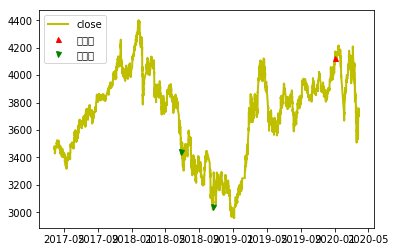

In [140]:
import matplotlib.pyplot as plt
dt0=data_df['close']
plt.subplot(1,1,1)
plt.plot(dt0, color='y', lw=2.)
plt.plot(dt0, '^', markersize=5, color='r', label='顶背离', markevery=join_beili[0])
plt.plot(dt0, 'v', markersize=5, color='g', label='底背离', markevery=join_beili[1])
plt.legend()
plt.show()

如果如下规则进行交易

* 如果出现底背离，则买入证券
* 如果出现顶背离，则卖出证券

绘制指数和策略对应的收益率曲线

In [141]:
r_i=data_df['close']/data_df['close'].shift(1)
cumr_i=[1]
cumr_s=[1]
hold_flag=0
for i in range(1,data_df.shape[0]-2):
    cumr_i.append(cumr_i[i-1]*r_i[i])
    if i in join_beili[1] and hold_flag==0: # 上升拐点且未持有
        hold_flag=1
        print(i,'buy')
    elif i in join_beili[0] and hold_flag==1: # 下降拐点且持有
        hold_flag=0
        print(i,'sell')
    if hold_flag==1:
        cumr_s.append(cumr_s[i-1]*r_i[i])
    else:
        cumr_s.append(cumr_s[i-1])
len(cumr_s)

4880 buy
10800 sell


11692

              index      stratety
count  11692.000000  11692.000000
mean       1.072808      1.033282
std        0.089188      0.079929
min        0.853246      0.855362
25%        1.004138      1.000000
50%        1.093749      1.000000
75%        1.135861      1.102468
max        1.268648      1.191183


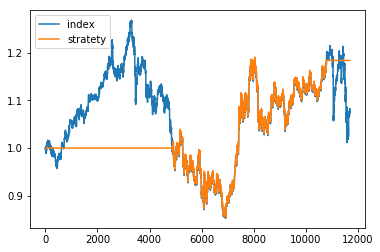

,信息比率,累计收益率,年化收益率,每日收益率,年化波动率,最大每日收益,最大每日损失,上涨天数,下跌天数,胜率,上涨时平均每日收益率,下跌时平均每日收益率,盈亏比,最大回撤
index,0.058226,1.077626,0.002655,0.000011,0.045597,0.02715,-0.072546,5803.0,5880.0,0.496705,0.001882,-0.001836,1.024827,0.327437
stratety,0.125501,1.184237,0.004207,0.000017,0.033521,0.02715,-0.041362,2914.0,3004.0,0.492396,0.002057,-0.001931,1.065573,0.177184


In [142]:
df2=pd.DataFrame([cumr_i,cumr_s]).T
df2.columns=['index','stratety']
print(df2.describe())
df2.plot()
plt.show()

from Ratio import ratio
single_day_r=(df2/(df2).shift(1))-1 # 计算指数和策略的单日收益率
result=ratio().cal_ratio(single_day_r)
result.T